In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [3]:
filmes = pd.read_csv('dados_filmes_tratados.csv')
filmes.head()

,Series_Title,Released_Year,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,Romance,Sci-Fi,Sport,Thriller,War,Western,Certificate_Livre,Certificate_Nao classificado,Certificate_Orientacao parental recomendada,Soma_notas
0,The Godfather,1972,175.0,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,...,0,0,0,0,0,0,False,False,False,14907376.4
1,The Dark Knight,2008,152.0,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,...,0,0,0,0,0,0,False,False,True,20729088.0
2,The Godfather: Part II,1974,202.0,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,...,0,0,0,0,0,0,False,False,False,10169568.0
3,12 Angry Men,1957,96.0,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,...,0,0,0,0,0,0,True,False,False,6208605.0
4,The Lord of the Rings: The Return of the King,2003,201.0,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,...,0,0,0,0,0,0,True,False,False,14620546.2


In [4]:
lista_generos = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
generos = filmes[lista_generos] # variavel dependente

#### Pré-processamento dos textos das sinópses.

In [5]:
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

def preprocessar_texto(texto):
    # Letra minúscula
    texto = texto.lower()

    # Remover números
    texto = re.sub(r"\d+", "", texto)

    # Remover pontuação, mas manter o '
    texto = re.sub(r"[^\w\s']", "", texto)

    # Tokenizar
    tokens = word_tokenize(texto)

    # Remover stopwords e aplicar lematização

    clean_tokens = []
    for word in tokens:
        if word not in stop_words and len(word)>2:
            palavra_lematizada = lemmatizer.lemmatize(word)
            clean_tokens.append(palavra_lematizada)

    return " ".join(clean_tokens)

In [6]:
overview = filmes['Overview'].apply(preprocessar_texto)
overview.head() # variavel independente

0    organized crime dynasty aging patriarch transf...
1    menace known joker wreaks havoc chaos people g...
2    early life career vito corleone new york city ...
3    jury holdout attempt prevent miscarriage justi...
4    gandalf aragorn lead world men sauron army dra...
Name: Overview, dtype: object

Instanciando o modelo W2V

In [ ]:
overview_tokenizado = filmes['Overview'].str.split()
w2v_modelo = Word2Vec(sentences=overview_tokenizado, vector_size=100, window=6, min_count=2)

# Classificação com MLP(Multilayer Perceptron) e Word2Vec 

Definindo MLP com 2 camadas ocultas, 192 neurônios ocultos e função de ativação ReLU.

In [17]:
class MLP(nn.Module):
    def __init__(self, tam_entradas, tam_saidas):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(tam_entradas, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, tam_saidas)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.out(x) 
        x = self.sigmoid(x)
        return x

O Word2Vec faz a vetorização de cada palavra presente, de modo que cada sinópse será uma vetor de palavras(que também são vetores). Por isso, para realizar uma análise inicial, vou retirar a média das palavras presentes em cada sinópse de filme e alimenta-la ao modelo, de modo que teremos um sentigo geral(gist), do texto, que pode ser capturado pela MLP.  

In [ ]:
def media_vetores_sinopse(lista_token, model):
    vetores = []
    for palavra in lista_token:
        if palavra in model.wv:
            vetores.append(model.wv[palavra])
    if len(vetores) == 0:
        return np.zeros(model.vector_size)
    
    return np.mean(vetores, axis=0)

overview_w2v = []
for lista_token in overview_tokenizado:
    overview_w2v.append(media_vetores_sinopse(lista_token, w2v_modelo))

X_treino, X_teste, y_treino, y_teste = train_test_split(overview_w2v, generos, test_size=0.3, random_state=0)

X_treino_tensor = torch.tensor(X_treino, dtype=torch.float32) # transformando em tensores
X_teste_tensor = torch.tensor(X_teste, dtype=torch.float32)

y_treino_tensor = torch.tensor(y_treino.to_numpy(), dtype=torch.float32)
y_teste_tensor = torch.tensor(y_teste.to_numpy(), dtype=torch.float32)


#### Treinamento

In [20]:
tam_entradas = X_treino_tensor.shape[1] # tamanho da camada de entrada(tamanho do vetor w2v)
tam_saidas = y_treino_tensor.shape[1]  # tamanho da camada de saida(quantidade de generos possíveis)

modelo = MLP(tam_entradas, tam_saidas)
optimizer = optim.Adam(modelo.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()
batch_size = 32
epochs = 100

treino_dataset = TensorDataset(X_treino_tensor, y_treino_tensor)
treino_loader = DataLoader(dataset=treino_dataset, batch_size=batch_size, shuffle=True)

teste_dataset = TensorDataset(X_teste_tensor, y_teste_tensor)
teste_loader = DataLoader(dataset=teste_dataset, batch_size=batch_size, shuffle=False)


custo_epocas = []
modelo.train()
for _ in range(epochs):
    custo_total_epoca = 0

    for batch_X, batch_y in treino_loader:
        outputs = modelo(batch_X)
        loss = loss_fn(outputs, batch_y)
            
        optimizer.zero_grad()   
        loss.backward()        
        optimizer.step()        

        custo_total_epoca += loss.item()
    custo_epocas.append(custo_total_epoca/len(treino_loader))
modelo.eval()

all_preds = []
all_labels = []


with torch.no_grad():
    for batch_X, batch_y in teste_loader:
        outputs = modelo(batch_X)
        predictions = (outputs > 0.5).float()

        all_preds.append(predictions.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())


all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

#### Resultados

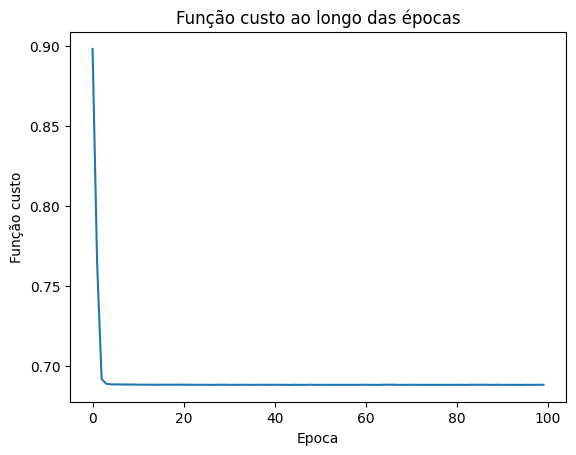

In [31]:
plt.plot(range(epochs), custo_epocas)
plt.title('Função custo ao longo das épocas')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

In [32]:
# Métricas mais detalhadas: Precisão, Recall e F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='samples', zero_division=0)

print(f'Precisão: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precisão: 0.7133333333333334
Recall: 0.3205555555555556
F1-Score: 0.4266666666666667


In [33]:
labels_flat = all_labels.flatten()
preds_flat = all_preds.flatten()

acuracia_por_rotulo = accuracy_score(labels_flat, preds_flat)

print(f'Acurácia de gêneros previstos(generos corretos/total de generos): {acuracia_por_rotulo}')

Acurácia de gêneros previstos(generos corretos/total de generos): 0.8984126984126984


# Considerações finais 

O modelo ainda não tem tanta capacidade de previsão assim, apesar de uma alta acurácia, apresentou um f1-score relativamente baixo, que é uma métrica muito mais importante no caso de classes(gêneros de filme) desbalanceadas. 

Ainda sim, os resultados mostram que é sim possível realizar a previsão de gêneros de filme baseando-se apenas nas sinópses dos filmes. Poderíamos obter resultados muito mais significativos se a distribuição geral de gêneros fosse mais balanceadas, já que, no nosso dataset, existem muito mais filmes de drama(700+) do que filmes de outras categorias. 

Em geral o modelo obteve uma performance boa dentro das suas limitações, obtendo uma acurácia de gêneros de aproximadamente 90%(previu 90% de todos os gêneros corretamente), precisão de 71%, revocação de 32% e f1-score de 0,43. 